In [1]:
%load_ext autoreload
%autoreload 2

from utils.hamiltonians import Max3satHamiltonian
from utils.qaoa import QAOA
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from utils.circuit_utils import calculate_expected_fidelity, calculate_expected_fidelity_ideal, calculate_swap_overhead
from utils.experiments import SuperconductingExperiment
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator
from utils.fake_backend import create_fake_heavy_hex_backend
import numpy as np
import pandas as pd

hamiltonian = Max3satHamiltonian("./instances/uf20-01.cnf")

print(hamiltonian.formula.nv, hamiltonian.formula.clauses)
print(hamiltonian.get_pauli_list(), len(hamiltonian.get_pauli_list()))

20 [[4, -18, 19], [3, 18, -5], [-5, -8, -15], [-20, 7, -16], [10, -13, -7], [-12, -9, 17], [17, 19, 5], [-16, 9, 15], [11, -5, -14], [18, -10, 13], [-3, 11, 12], [-6, -17, -8], [-18, 14, 1], [-19, -15, 10], [12, 18, -19], [-8, 4, 7], [-8, -9, 4], [7, 17, -15], [12, -7, -14], [-10, -11, 8], [2, -15, -11], [9, 6, 1], [-11, 20, -17], [9, -15, 13], [12, -7, -17], [-18, -2, 20], [20, 12, 4], [19, 11, 14], [-16, 18, -4], [-1, -17, -19], [-13, 15, 10], [-12, -14, -13], [12, -14, -7], [-7, 16, 10], [6, 10, 7], [20, 14, -16], [-19, 17, 11], [-7, 1, -20], [-5, 12, 15], [-4, -9, -13], [12, -11, -7], [-5, 19, -8], [1, 16, 17], [20, -14, -15], [13, -4, 10], [14, 7, 10], [-5, 9, 20], [10, 1, -19], [-16, -15, -1], [16, 3, -11], [-15, -10, 4], [4, -15, -3], [-10, -16, 11], [-8, 12, -5], [14, -6, 12], [1, 6, 11], [-13, -5, -1], [-7, -2, 12], [1, -20, 19], [-2, -13, -8], [15, 18, 4], [-11, 14, 9], [-6, -15, -2], [5, -12, -15], [-6, 17, 5], [-13, 5, -19], [20, -1, 14], [9, -17, 15], [-5, 19, -18], [-12, 

In [2]:
basis_gates = ["rx", "rz", "x", "y", "z", "h", "id", "cz"]
depth = 1
qaoa = QAOA(hamiltonian)
qaoa_circuit, cost_params, mixer_params = qaoa.naive_qaoa_circuit(depth)
bound_circuit = qaoa_circuit.assign_parameters({cost_params: [np.pi / 2.123 for param in cost_params], mixer_params: [np.pi / 3.123 for param in mixer_params]})
bound_circuit.measure_all()
transpiled_circuit = transpile(bound_circuit, basis_gates=basis_gates, optimization_level=3)

In [3]:
service = QiskitRuntimeService()

In [4]:
backend = service.backend("ibm_sherbrooke")

In [5]:
print(backend.basis_gates)

['ecr', 'id', 'rz', 'sx', 'x']


In [5]:
eagle_circuit = transpile(bound_circuit, backend=backend, optimization_level=3)

print(eagle_circuit.depth(), bound_circuit.depth())
print(eagle_circuit.count_ops(), bound_circuit.count_ops())

2585 191
OrderedDict([('rz', 4466), ('sx', 2911), ('ecr', 1281), ('x', 364), ('measure', 20), ('barrier', 1)]) OrderedDict([('cx', 295), ('rz', 231), ('rx', 20), ('measure', 20), ('barrier', 1)])


In [23]:
ost_operator = hamiltonian.get_sparse_pauli_operator()
observable = cost_operator.apply_layout(eagle_circuit.layout)
estimator = Estimator(backend=backend)

In [25]:
job = estimator.run([(eagle_circuit, observable)])

In [29]:
print(f"Job ID: {job.job_id()}")
print(f"Job Status: {job.status()}")

Job ID: crx7kt77wv80008fkzm0
Job Status: QUEUED


In [31]:
least_busy_backend = service.least_busy(operational=True, simulator=False)

print(least_busy_backend)

<IBMBackend('ibm_osaka')>


In [46]:
sampler = Sampler(backend=backend)
estimator = Estimator(backend=backend)
eagle_circuit = transpile(bound_circuit, backend=backend, optimization_level=3)
observable = cost_operator.apply_layout(eagle_circuit.layout)

print(eagle_circuit.depth(), bound_circuit.depth())
print(eagle_circuit.count_ops(), bound_circuit.count_ops())

2539 191
OrderedDict([('rz', 4546), ('sx', 2892), ('ecr', 1288), ('x', 405), ('measure', 20), ('barrier', 1)]) OrderedDict([('cx', 295), ('rz', 231), ('rx', 20), ('measure', 20), ('barrier', 1)])


In [49]:
sampler_job = sampler.run([eagle_circuit], shots=256)

In [43]:
job = estimator.run([(eagle_circuit, observable)])

/home/lax/Desktop/FPQA-MAX3-SAT/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 623.1034379365619 quantum seconds, but you only have 600 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


In [7]:
print(calculate_expected_fidelity(eagle_circuit, backend))
print(calculate_swap_overhead(transpiled_circuit, eagle_circuit))

(7.195686173181647e-12, 0.0001808796796848703, 152648674309, 6073)
328


In [6]:
experiment = SuperconductingExperiment("superconducting_1", ["uf20-01.cnf", "uuf50-01.cnf", "uuf75-01.cnf", "uuf100-01.cnf", "uuf125-01.cnf"], backend)

experiment.run(max_depth=1, max_iterations=10)

>>> Starting experiments with Problem: uf20-01.cnf ...
>>> Parametrized circuit created, Depth: 1 ...
>>> Transpiling parametrized circuit, Iteration: 0 ...
>>> Transpiling parametrized circuit, Iteration: 1 ...
>>> Transpiling parametrized circuit, Iteration: 2 ...
>>> Transpiling parametrized circuit, Iteration: 3 ...
>>> Transpiling parametrized circuit, Iteration: 4 ...
>>> Transpiling parametrized circuit, Iteration: 5 ...
>>> Transpiling parametrized circuit, Iteration: 6 ...
>>> Transpiling parametrized circuit, Iteration: 7 ...
>>> Transpiling parametrized circuit, Iteration: 8 ...
>>> Transpiling parametrized circuit, Iteration: 9 ...
>>> Starting experiments with Problem: uuf50-01.cnf ...
>>> Parametrized circuit created, Depth: 1 ...
>>> Transpiling parametrized circuit, Iteration: 0 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 1 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 2 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 3 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 4 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 5 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 6 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 7 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 8 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 9 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Starting experiments with Problem: uuf75-01.cnf ...
>>> Parametrized circuit created, Depth: 1 ...
>>> Transpiling parametrized circuit, Iteration: 0 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 1 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 2 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 3 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 4 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 5 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 6 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 7 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 8 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 9 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Starting experiments with Problem: uuf100-01.cnf ...
>>> Parametrized circuit created, Depth: 1 ...
>>> Transpiling parametrized circuit, Iteration: 0 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 1 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 2 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 3 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 4 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 5 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 6 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 7 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 8 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 9 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Starting experiments with Problem: uuf125-01.cnf ...
>>> Parametrized circuit created, Depth: 1 ...
>>> Transpiling parametrized circuit, Iteration: 0 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 1 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 2 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 3 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 4 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 5 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 6 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 7 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 8 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


>>> Transpiling parametrized circuit, Iteration: 9 ...


/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots_without_decoherence = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity * decoherence_fidelity)
/home/ogz/Desktop/FPQA-MAX3-SAT/utils/circuit_utils.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  estimated_shots = np.log(1 - DESIRED_SUCCESS_PROBABILITY) / np.log(1 - fidelity)


,Name,Hardware,QAOA Depth,Average Circuit Depth,Ideal Fidelity,Ideal Estimated Shots,Fidelity with Decoherence,Estimated Shots with Decoherence for 2/3 Success Rate,Fidelity without Decoherence,Estimated Shots without Decoherence for 2/3 Success Rate,Average Swap Overhead,Average Number of Two Qubit Gates,Iterations
0,uf20-01.cnf,ibm_sherbrooke,1,2511.6,7.831619e-07,1.494248e+06,5.805747e-11,1.561356e+11,4.142063e-04,3372.240684,327,1277,10
1,uuf50-01.cnf,ibm_sherbrooke,1,8449.7,5.061086e-31,-inf,3.895765e-69,-inf,1.686629e-26,-inf,1841,6386,10
2,uuf75-01.cnf,ibm_sherbrooke,1,14325.6,3.985309e-61,-inf,0.000000e+00,-inf,0.000000e+00,-inf,3793,12778,10
3,uuf100-01.cnf,ibm_sherbrooke,1,20762.0,5.615926e-98,-inf,0.000000e+00,-inf,0.000000e+00,-inf,6278,20762,10
4,uuf125-01.cnf,ibm_sherbrooke,1,26560.6,6.266132e-141,-inf,0.000000e+00,-inf,0.000000e+00,-inf,9221,30127,10


In [10]:
fake_backend = create_fake_heavy_hex_backend(7, 6)

print(fake_backend.name)
print(fake_backend.num_qubits)
print(fake_backend.coupling_map)
print(fake_backend.target["ecr"][(0,1)])
print(fake_backend.basis_gates)

generic_backend_261q
261
[[0, 1], [0, 25], [25, 32], [1, 2], [2, 3], [3, 4], [4, 5], [4, 26], [26, 36], [5, 6], [6, 7], [7, 8], [8, 9], [8, 27], [27, 40], [9, 10], [10, 11], [11, 12], [12, 13], [12, 28], [28, 44], [13, 14], [14, 15], [15, 16], [16, 17], [16, 29], [29, 48], [17, 18], [18, 19], [19, 20], [20, 21], [20, 30], [30, 52], [21, 22], [22, 23], [23, 24], [24, 31], [31, 56], [32, 33], [33, 34], [34, 35], [34, 59], [59, 68], [35, 36], [36, 37], [37, 38], [38, 39], [38, 60], [60, 72], [39, 40], [40, 41], [41, 42], [42, 43], [42, 61], [61, 76], [43, 44], [44, 45], [45, 46], [46, 47], [46, 62], [62, 80], [47, 48], [48, 49], [49, 50], [50, 51], [50, 63], [63, 84], [51, 52], [52, 53], [53, 54], [54, 55], [54, 64], [64, 88], [55, 56], [56, 57], [57, 58], [58, 65], [65, 92], [66, 67], [66, 93], [93, 100], [67, 68], [68, 69], [69, 70], [70, 71], [70, 94], [94, 104], [71, 72], [72, 73], [73, 74], [74, 75], [74, 95], [95, 108], [75, 76], [76, 77], [77, 78], [78, 79], [78, 96], [96, 112], [7

/tmp/ipykernel_15818/2042458552.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(
/home/ogz/Desktop/FPQA-MAX3-SAT/.venv-fpqa/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5 is greater than n_features=3. All the features will be returned.
  warnings.warn(
/home/ogz/Desktop/FPQA-MAX3-SAT/.venv-fpqa/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


<Axes: ylabel='None'>

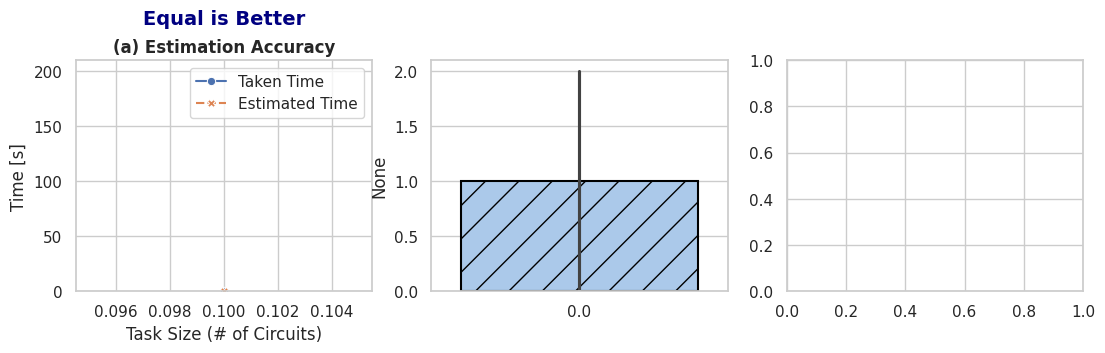

In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

fig = plt.figure(figsize=(13, 3))
nrows = 1
ncols = 3
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
axis = [fig.add_subplot(gs[i, j]) for i in range(nrows) for j in range(ncols)]
sns.set_theme(style="whitegrid")

estimations = [(0.1, 0.2, 0.3)]
df_data = []

for tup in estimations:
    first_num, second_num, third_num = tup
    df_data.append({'Task Size': first_num, 'Type': 'Taken Time', 'Time': second_num})
    df_data.append({'Task Size': first_num, 'Type': 'Estimated Time', 'Time': third_num})

prediction_df = pd.DataFrame(df_data)

sns.lineplot(
    prediction_df, 
    x=prediction_df['Task Size'], 
    y=prediction_df['Time'], 
    ax=axis[0], 
    hue=prediction_df["Type"], 
    palette=sns.color_palette("deep"), 
    style=prediction_df['Type'],
    markers=True
)

axis[0].set_title("(a) Estimation Accuracy", fontsize=12, fontweight="bold")
axis[0].set_xlabel("Task Size (# of Circuits)")
axis[0].set_ylabel("Time [s]")
axis[0].set_ylim(0, 210)
axis[0].text(0.5, 1.18, "Equal is Better", ha="center", va="center", transform=axis[0].transAxes, fontweight="bold", color="navy", fontsize=14)
axis[0].legend()

# Plot f-score
f_score_selection = SelectKBest(score_func=f_regression, k=5)
f_score_selection.fit([[0.1, 0.2, 0.3], [0.1, 0.2, 0.3], [0.1, 0.2, 0.3]], [0, 1, 2])
scores = f_score_selection.scores_
scores = pd.Series(scores, index=[0, 1, 2]).sort_values(
    ascending=False
)
scores = scores.rename("test")

sns.barplot(
    x=scores.values, 
    y=scores.index,
    #orient = 'h',
    color=sns.color_palette("pastel")[0],
    edgecolor="black",
    hatch="/",
    linewidth=1.5,
    ax=axis[1],
)